## Síntese de um compensador PID pelo método do lugar das raízes (*root locus*)

*Adaptado do exemplo A-6-19 do livro*: 
> OGATA, K. (2001) Modern Control Engineering, 4th ed., Pearson.

A função de transferência de malha aberta de um *piloto automático para o modo longitudinal (pitch) de um avião*:

\begin{align*}
    L(s) = G(s)H(s) = \frac{K(s+a)}{s(s-b)(s^2 + 2\zeta \omega_n s + \omega_n^2)} = K \frac{N(s)}{D(s)}
\end{align*}
com:
\begin{align*}
    & N(s) = (s+a) \\
    & D(s) = s(s-b)(s^2 + 2\zeta \omega_n s + \omega_n^2)
\end{align*}

O sistema tem um polo de malha aberta no semi-plano direito e, provavelmente, deve ser apenas *condicionalmente estável*.

Adote-se $a=b=1$, $\zeta=0.5$ e $\omega_n=4$:

\begin{align*}
   L(s) = \frac{K(s+1)}{s(s-1)(s^2 + 4s + 16)}
\end{align*}

Neste caso, o sistema é do tipo 1, tendo um zero em $z_1 = -1$ e quatro polos em $p_0=0$ (multiplicidade algébrica 1), $p_1=+1$ e $p_{2,3}=-2 \pm 2\sqrt{3} \mathsf{j}$.


In [1]:
# !pip install matplotlib ipympl jupyter

In [2]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib widget

import numpy as np
import sympy as sp
import control as ct
from tbcontrol.symbolic import routh

s = ct.tf([1, 0], [1])

In [3]:
# Paleta de cores
cp = {
    'red': (1.0, 0.349, 0.369, 1.0),
    'green': (0.541, 0.788, 0.149, 1.0),
    'blue': (0.098, 0.510, 0.769, 1.0),
    'lred': (1.0, 0.588, 0.6, 1.0),
    'lgreen': (0.722, 0.894, 0.443, 1.0),
    'lblue': (0.369, 0.706, 0.918, 1.0),
    'orange': (1.0, 0.506, 0.227, 1.0),
    'yellow': (1.0, 0.792, 0.227, 1.0),
    'pink': (1.0, 0.349, 0.611, 1.0),
    'purple': (0.416, 0.298, 0.576, 1.0),
    'turquoise': (0.098, 0.761, 0.769, 1.0),
    'brown': (0.576, 0.380, 0.298, 1.0)
}

### 1. Função de transferência de malha aberta

In [4]:
zeros = np.array([-1])
poles = np.array([0, +1, -2 + (2j * np.sqrt(3)), -2 - (2j * np.sqrt(3))])

N = ct.tf(np.poly(zeros), [1])
D = ct.tf(np.poly(poles), [1])

L_0 = N/D
L_0

TransferFunction(array([1., 1.]), array([  1.,   3.,  12., -16.,   0.]))

### 2. Determinação dos ganhos críticos via tabela de Routh

In [5]:
s_s = sp.symbols('s')
N_s = sp.Poly(np.poly(zeros), s_s)
D_s = sp.Poly(np.poly(poles), s_s)
N_s/D_s

(1.0*s + 1.0)/(1.0*s**4 + 3.0*s**3 + 12.0*s**2 - 16.0*s)

In [6]:
K_c = sp.symbols('K_c')
B_s = K_c * N_s + D_s

table_B = routh(B_s)
table_B

Matrix([
[                                                                                                            1.0,           12.0, 1.0*K_c],
[                                                                                                            3.0, 1.0*K_c - 16.0,       0],
[                                                                       17.3333333333333 - 0.333333333333333*K_c,        1.0*K_c,       0],
[(0.333333333333333*K_c**2 - 19.6666666666667*K_c + 277.333333333333)/(0.333333333333333*K_c - 17.3333333333333),              0,       0],
[                                                                                                            K_c,              0,       0]])

In [7]:
sp.solve(table_B[2, 0] > 0, K_c)

(-oo < K_c) & (K_c < 52.0)

In [8]:
sp.solve(table_B[3, 0] > 0, K_c)

((23.3153415615735 < K_c) & (K_c < 35.6846584384265)) | ((52.0 < K_c) & (K_c < oo))

De fato, a planta é *condicionalmente estável*, ou seja, é possível ter um comportamento estável em malha fechada com controlador *proporcional* ($K_c$) se, e somente se: $$23.32 < K_c < 35.68$$

### 3. Síntese de um controlador PID via lugar das raízes

#### 3.1. Síntese de um compensador proporcional 

Lugar das raízes de $L(s)$

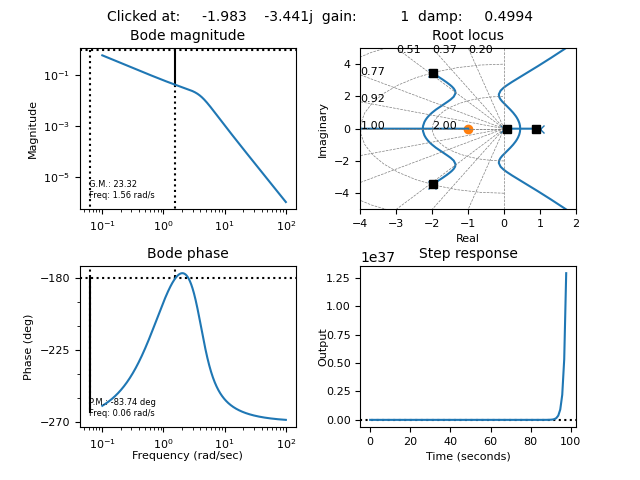

In [9]:
plt.ion()  # ativar o modo interativo
ct.sisotool(L_0, xlim_rlocus=(-4, 2), ylim_rlocus=(-5, 5),
            rlocus_grid=True)  # ferramenta interativa SISO Design Tool
plt.draw()  # desenhar a janela interativa

A partir do lugar das raízes $L(s)$, pode-se escolher como valor inicial para o ganho proporcional $K_p = 30.0$.

#### 3.2. Síntese de um compensador PI

Podemos agora trocar o controlador *proporcional* (P) por um *proporcional-integral* (PI), de tal forma que a nova FTMA se torna:
\begin{align*}
    L_{\text{PI}}(s) = \left( K_p + \frac{K_i}{s} \right) \frac{N(s)}{D(s)}
\end{align*}
Assim, as novas raízes em malha fechada serão dadas por:
\begin{align*}
    & 1 + L_{\text{PI}}(s) = 0 
    \\
    & 1 + K_p \frac{N(s)}{D(s)} +  K_i \frac{N(s)}{s D(s)} = 0
    \\ 
    & s[D(s) + K_p N(s)] +  K_i N(s) = 0
    \\ 
    & 1 +  K_i \underbrace{\frac{N(s)}{s [D(s) + K_p N(s)]}}_{\displaystyle L_1(s)} = 0
\end{align*}


In [10]:
K_p = 30.0
L_1 = N/(s * (D + K_p * N))
L_1

TransferFunction(array([1., 1.]), array([ 1.,  3., 12., 14., 30.,  0.]))

Lugar das raízes de $L_1(s)$ e ajuste de $K_i$ 

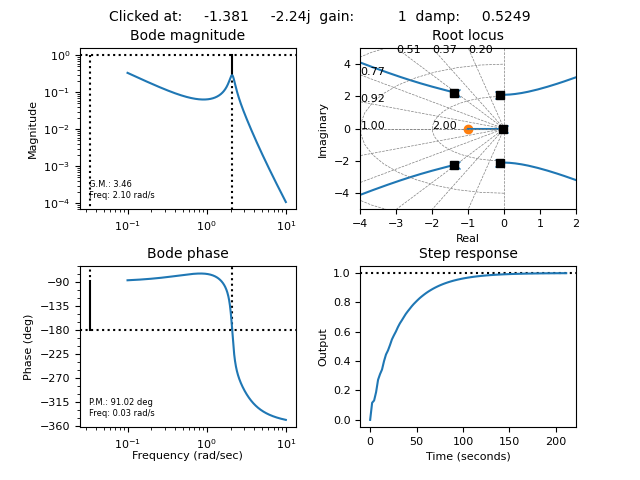

In [21]:
plt.ion()  # ativar o modo interativo
ct.sisotool(L_1, xlim_rlocus=(-4, 2), ylim_rlocus=(-5, 5),
            rlocus_grid=True)  # ferramenta interativa SISO Design Tool
plt.draw()  # desenhar a janela interativa

A partir da análise do lugar das raízes para $L_1(s)$, chega-se a $K_i = 2.5 \ \text{s}^{-1}$ como escolha razoável para o ganho integral.

Assim pode-se calcular $T_i$ pela expressão:
$$T_i = \frac{K_p}{K_i}$$

In [12]:
K_i = 2.5
T_i = K_p/K_i
T_i

12.0

Assumindo os valor calculados para $T_i$, pode-se fazer um ajuste fino para $K_c$:
\begin{align*}
    L_{\text{PI}}(s) = K_c \left(1 + \frac{1}{T_i s}\right) \frac{N(s)}{D(s)}
\end{align*}
As raízes de malha fechada serão dadas por:
\begin{align*}
    & 1 + L_{\text{PI}}(s) = 0 
    \\
    & 1 +  K_c \left(1 + \frac{1}{T_i s} \right) \frac{N(s)}{D(s)} = 0
    \\
    & 1 +  K_c \underbrace{\frac{(1 + T_i s)N(s)}{s T_i D(s)}}_{\displaystyle L_2(s)} = 0
\end{align*}


In [13]:
L_2 = (1 + T_i * s) * N/(s * T_i * D)
L_2

TransferFunction(array([12., 13.,  1.]), array([  12.,   36.,  144., -192.,    0.,    0.]))

Lugar das raízes de $L_2(s)$ e ajuste fino de $K_c$

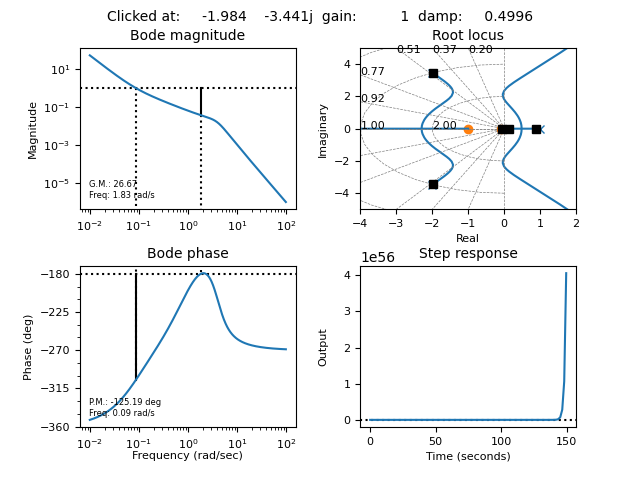

In [14]:
plt.ion()  # ativar o modo interativo
ct.sisotool(L_2, xlim_rlocus=(-4, 2), ylim_rlocus=(-5, 5),
            rlocus_grid=True)  # ferramenta interativa SISO Design Tool
plt.draw()  # desenhar a janela interativa

Obtém-se assim $K_c = 30$, o que leva o seguinte compensador PI:

In [15]:
K_c_PI = 30.0

G_c_PI = K_c_PI * (1 + 1/(T_i * s))
G_c_PI

TransferFunction(array([360.,  30.]), array([12.,  0.]))

Diagrama de Bode do compensador PID sintetizado

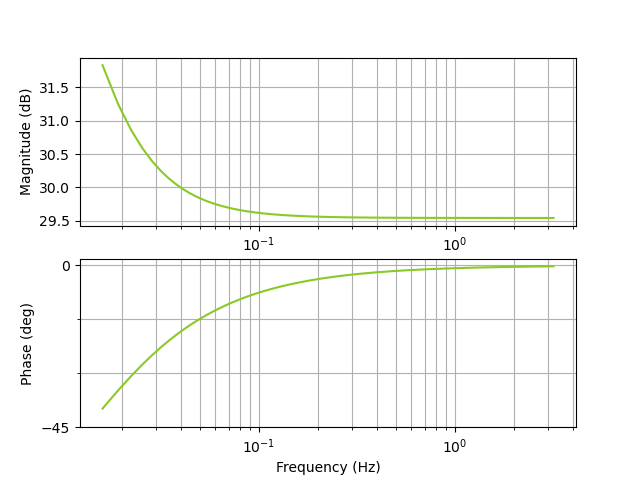

In [20]:
plt.figure()
G_c_M, G_c_φ, G_c_ω = ct.bode_plot(G_c_PI,
                                   omega=np.linspace(0.1, 20, 1001),
                                   color=cp['green'],
                                   dB=True, Hz=True)

#### 3.3. Síntese de um compensador PID

Podemos agora trocar o controlador *proporcional-integral* (PI) por um *proporcional-integral-derivativo* (PID), de tal forma que a nova FTMA se torna:
\begin{align*}
    L_{\text{PID}}(s) = \left( K_p + \frac{K_i}{s} + K_d s \right) \frac{N(s)}{D(s)}
\end{align*}
Assim, as novas raízes em malha fechada serão dadas por:
\begin{align*}
    & 1 + L_{\text{PID}}(s) = 0 
    \\
    & 1 + K_p \frac{N(s)}{D(s)} + K_i \frac{N(s)}{s D(s)} + \frac{K_d s N(s)}{D(s)} = 0
    \\ 
    & s D(s) + (K_p s + K_i)N(s) + K_d s^2 N(s) = 0
    \\ 
    & 1 +  K_d \underbrace{\frac{s^2 N(s)}{s D(s) + (K_p s + K_i)N(s)}}_{\displaystyle L_3(s)} = 0
\end{align*}

In [17]:
L_3 = (s * s * N)/(s * D + (K_p * s + K_i) * N)
L_3

TransferFunction(array([1., 1., 0., 0.]), array([ 1. ,  3. , 12. , 14. , 32.5,  2.5]))

Lugar das raízes de $L_3(s)$ e ajuste de $K_d$

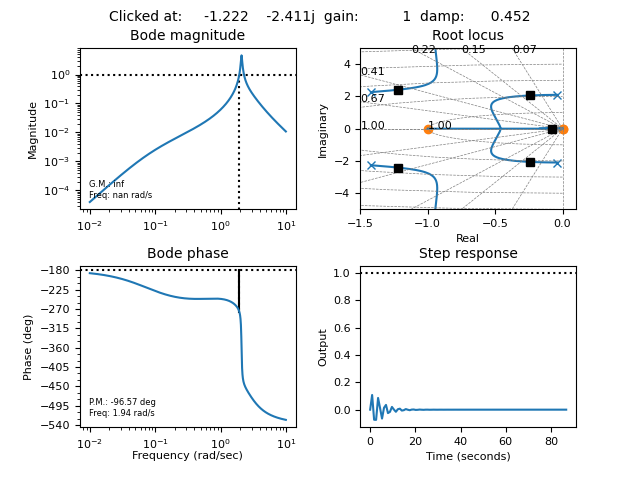

In [18]:
plt.ion()  # ativar o modo interativo
ct.sisotool(L_3, xlim_rlocus=(-1.5, 0.1), ylim_rlocus=(-5, 5),
            rlocus_grid=True)  # ferramenta interativa SISO Design Tool
plt.draw()  # desenhar a janela interativa

A partir da análise do lugar das raízes para $L_3(s)$, chega-se a $K_d = 110 \ \text{s}$ como escolha razoável para o ganho derivativo.

Assim pode-se calcular $T_d$ pelas expressão:
$$T_d = \frac{K_d}{K_p}$$

In [24]:
K_d = 110.0
T_d = K_d/K_p
T_d

3.6666666666666665

Finalmente, assumindo os valores calculados para $T_i$ e $T_d$, pode-se fazer um ajuste fino para $K_c$:
\begin{align*}
    L_{\text{PID}}(s) = K_c \left(1 + \frac{1}{T_i s} + T_d s \right) \frac{N(s)}{D(s)}
\end{align*}
As raízes de malha fechada serão dadas por:
\begin{align*}
    & 1 + L_{\text{PID}}(s) = 0 
    \\
    & 1 +  K_c \left(1 + \frac{1}{T_i s} + T_d s \right) \frac{N(s)}{D(s)} = 0
    \\
    & 1 +  K_c \underbrace{\frac{(1 + T_i s + T_d T_i s^2)N(s)}{s T_i D(s)}}_{\displaystyle L_4(s)} = 0
\end{align*}


In [25]:
L_4 = ((1 + T_i * s + T_d * T_i * s * s) * N)/(s * T_i * D)
L_4

TransferFunction(array([44., 56., 13.,  1.]), array([  12.,   36.,  144., -192.,    0.,    0.]))

Lugar das raízes de $L_4(s)$ e ajuste fino de $K_c$

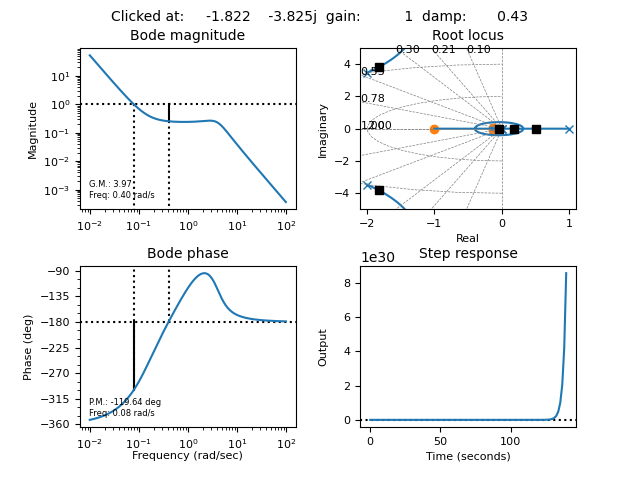

In [26]:
plt.ion()  # ativar o modo interativo
ct.sisotool(L_4, xlim_rlocus=(-2.1, 1.1), ylim_rlocus=(-5, 5),
            rlocus_grid=True)  # ferramenta interativa SISO Design Tool
plt.draw()  # desenhar a janela interativa

Assim, adotando $K_c = 15$, tem-se o seguinte compensador PID:

In [27]:
K_c_PID = 15.0
N_d = 1000

G_c_PID = K_c_PID * (1 + 1/(T_i * s) + (T_d * s)/(1 + T_d * s/N_d))
G_c_PID

TransferFunction(array([660660., 180055.,  15000.]), array([   44., 12000.,     0.]))

Diagrama de Bode do compensador PID sintetizado

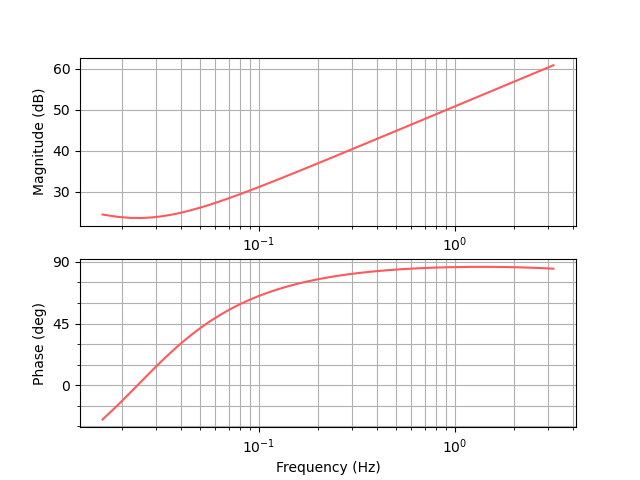

In [32]:
plt.figure()
G_c_M, G_c_φ, G_c_ω = ct.bode_plot(G_c_PID,
                                omega=np.linspace(0.1, 20, 1001),
                                color=cp['red'],
                                dB=True, Hz=True)

#### 3.4. Síntese de um compensador PD

Podemos agora trocar o controlador *proporcional* (P) por um *proporcional-derivativo* (PD), de tal forma que a nova FTMA se torna:
\begin{align*}
    L_{\text{PD}}(s) = \left( K_p + K_d s \right) \frac{N(s)}{D(s)}
\end{align*}
Assim, as novas raízes em malha fechada serão dadas por:
\begin{align*}
    & 1 + L_{\text{PD}}(s) = 0 
    \\
    & 1 + K_p \frac{N(s)}{D(s)} + \frac{K_d s N(s)}{D(s)} = 0
    \\ 
    & D(s) + K_p N(s) + K_d s N(s) = 0
    \\ 
    & 1 +  K_d \underbrace{\frac{s N(s)}{D(s) + K_p N(s)}}_{\displaystyle L_5(s)} = 0
\end{align*}

In [29]:
L_5 = (s * N)/(D + K_p * N)
L_5

TransferFunction(array([1., 1., 0.]), array([ 1.,  3., 12., 14., 30.]))

Lugar das raízes de $L_5(s)$ e ajuste de $K_d$

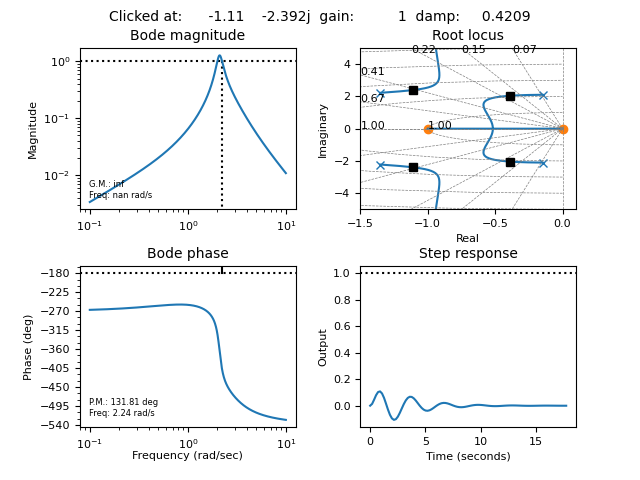

Clicked at    -0.5367    +1.951j gain      1.521 damp     0.2653


In [30]:
plt.ion()  # ativar o modo interativo
ct.sisotool(L_5, xlim_rlocus=(-1.5, 0.1), ylim_rlocus=(-5, 5),
            rlocus_grid=True)  # ferramenta interativa SISO Design Tool
plt.draw()  # desenhar a janela interativa

A partir da análise do lugar das raízes para $L_5(s)$, chega-se a $K_d = 4 \ \text{s}$ como escolha razoável para o ganho derivativo.

Assim pode-se calcular $T_d$ pelas expressão:
$$T_d = \frac{K_d}{K_p}$$

In [33]:
K_d = 4
T_d = K_d/K_p
T_d

0.13333333333333333

Finalmente, assumindo os valor calculado para $T_d$, pode-se fazer um ajuste fino para $K_c$:
\begin{align*}
    L_{\text{PD}}(s) = K_c \left(1 + T_d s \right) \frac{N(s)}{D(s)}
\end{align*}
As raízes de malha fechada serão dadas por:
\begin{align*}
    & 1 + L_{\text{PD}}(s) = 0 
    \\
    & 1 +  K_c \underbrace{\frac{\left(1 + T_d s \right) N(s)}{D(s)}}_{\displaystyle L_6(s)} = 0
\end{align*}

In [34]:
L_6 = ((1 + T_d * s) * N)/D
L_6

TransferFunction(array([0.13333333, 1.13333333, 1.        ]), array([  1.,   3.,  12., -16.,   0.]))

Lugar das raízes de $L_6(s)$ e ajuste fino de $K_c$

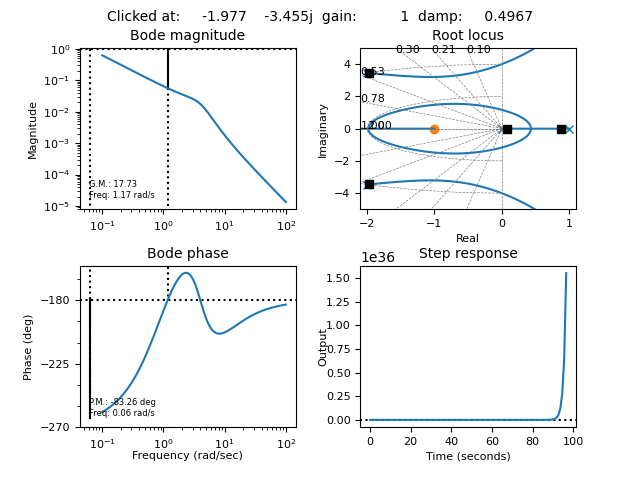

In [35]:
plt.ion()  # ativar o modo interativo
ct.sisotool(L_6, xlim_rlocus=(-2.1, 1.1), ylim_rlocus=(-5, 5),
            rlocus_grid=True)  # ferramenta interativa SISO Design Tool
plt.draw()  # desenhar a janela interativa

Assim, adotando $K_c = 30, tem-se o seguinte compensador PD:


In [36]:
K_c_PD = 30
N_d = 1000

G_c_PD = K_c_PD * (1 + (T_d * s)/(1 + T_d * s/N_d))
G_c_PD

TransferFunction(array([ 4004., 30000.]), array([1.33333333e-01, 1.00000000e+03]))

Diagrama de Bode do compensador PD sintetizado

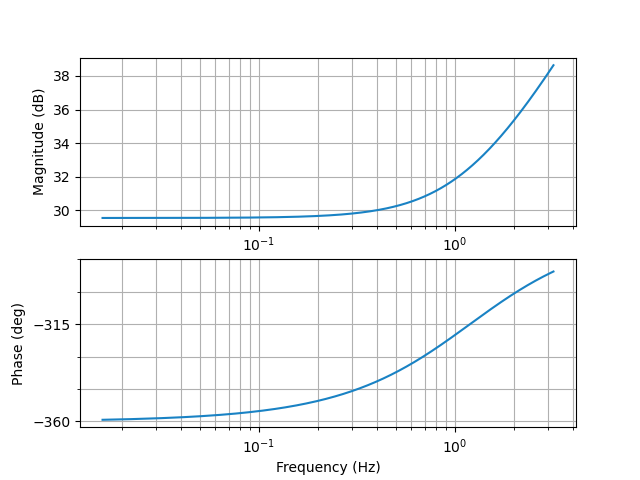

In [37]:
plt.figure()
G_c_M, G_c_φ, G_c_ω = ct.bode_plot(G_c_PD,
                                   omega=np.linspace(0.1, 20, 1001),
                                   color=cp['blue'],
                                   dB=True, Hz=True)

### 4. Análise das respostas em malha fechada com compensadores PI, PD e PID

#### 4.1. Função de transferência entre referência (r) e saída (c)

In [38]:
rc_tf_PI = ct.feedback(G_c_PI * L_0)
rc_tf_PD = ct.feedback(G_c_PD * L_0)
rc_tf_PID = ct.feedback(G_c_PID * L_0)
rc_tf_PID

TransferFunction(array([660660., 840715., 195055.,  15000.]), array([4.40000e+01, 1.21320e+04, 3.65280e+04, 8.03956e+05, 6.48715e+05,
       1.95055e+05, 1.50000e+04]))

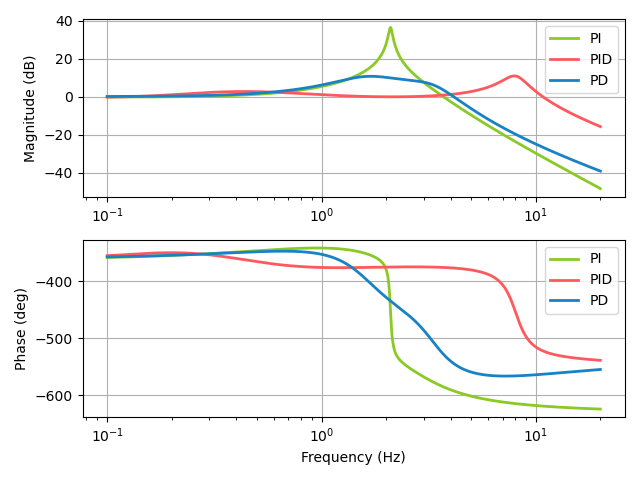

In [39]:
plt.figure()
plt.subplot(2, 1, 1)

mag_PI, phase_PI, omega_PI = ct.bode(
    rc_tf_PI, dB=True, Hz=True, omega_limits=(0.1, 20), plot=False)
mag_PID, phase_PID, omega_PID = ct.bode(
    rc_tf_PID, dB=True, Hz=True, omega_limits=(0.1, 20), plot=False)
mag_PD, phase_PD, omega_PD = ct.bode(
    rc_tf_PD, dB=True, Hz=True, omega_limits=(0.1, 20), plot=False)


plt.semilogx(omega_PI, 20 * np.log10(mag_PI),
             label='PI', color=cp['green'], linewidth=2)
plt.semilogx(omega_PID, 20 * np.log10(mag_PID),
             label='PID', color=cp['red'], linewidth=2)
plt.semilogx(omega_PD, 20 * np.log10(mag_PD),
             label='PD', color=cp['blue'], linewidth=2)
plt.ylabel('Magnitude (dB)')

# plt.title('Magnitude')
plt.grid()
plt.legend()

plt.subplot(2, 1, 2)
plt.semilogx(omega_PI, phase_PI * (180.0 / np.pi),
             label='PI', color=cp['green'], linewidth=2)
plt.semilogx(omega_PID, phase_PID * (180.0 / np.pi),
             label='PID', color=cp['red'], linewidth=2)
plt.semilogx(omega_PD, phase_PD * (180.0 / np.pi),
             label='PD', color=cp['blue'], linewidth=2)
plt.ylabel('Phase (deg)')
plt.xlabel('Frequency (Hz)')
# plt.title('Phase')
plt.grid()
plt.legend()

plt.tight_layout()
plt.show()

#### 4.2. Função de transferência entre referência (r) e entrada de controle (u)

In [40]:
ru_tf_PI = ct.feedback(G_c_PI, L_0)
ru_tf_PD = ct.feedback(G_c_PD, L_0)
ru_tf_PID = ct.feedback(G_c_PID, L_0)
ru_tf_PID

TransferFunction(array([  660660.,  2162035.,  8483085., -8364900., -2700880.,  -240000.,
              0.]), array([4.40000e+01, 1.21320e+04, 3.65280e+04, 8.03956e+05, 6.48715e+05,
       1.95055e+05, 1.50000e+04]))

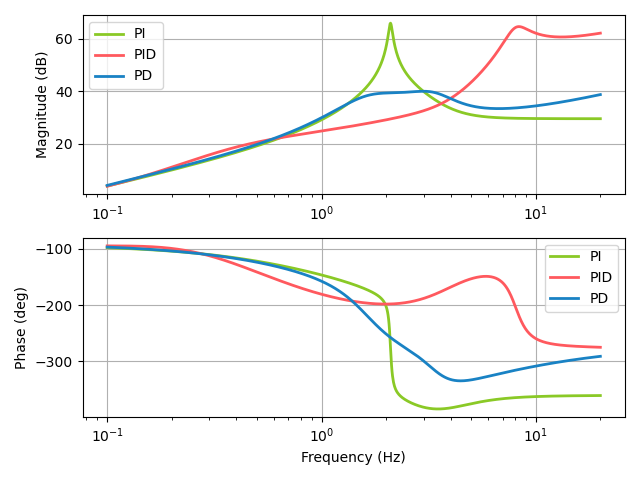

In [41]:
plt.figure()
plt.subplot(2, 1, 1)

mag_PI, phase_PI, omega_PI = ct.bode(
    ru_tf_PI, dB=True, Hz=True, omega_limits=(0.1, 20), plot=False)
mag_PID, phase_PID, omega_PID = ct.bode(
    ru_tf_PID, dB=True, Hz=True, omega_limits=(0.1, 20), plot=False)
mag_PD, phase_PD, omega_PD = ct.bode(
    ru_tf_PD, dB=True, Hz=True, omega_limits=(0.1, 20), plot=False)


plt.semilogx(omega_PI, 20 * np.log10(mag_PI),
             label='PI', color=cp['green'], linewidth=2)
plt.semilogx(omega_PID, 20 * np.log10(mag_PID),
             label='PID', color=cp['red'], linewidth=2)
plt.semilogx(omega_PD, 20 * np.log10(mag_PD),
             label='PD', color=cp['blue'], linewidth=2)
plt.ylabel('Magnitude (dB)')

# plt.title('Magnitude')
plt.grid()
plt.legend()

plt.subplot(2, 1, 2)
plt.semilogx(omega_PI, phase_PI * (180.0 / np.pi),
             label='PI', color=cp['green'], linewidth=2)
plt.semilogx(omega_PID, phase_PID * (180.0 / np.pi),
             label='PID', color=cp['red'], linewidth=2)
plt.semilogx(omega_PD, phase_PD * (180.0 / np.pi),
             label='PD', color=cp['blue'], linewidth=2)
plt.ylabel('Phase (deg)')
plt.xlabel('Frequency (Hz)')
# plt.title('Phase')
plt.grid()
plt.legend()

plt.tight_layout()
plt.show()

#### 4.3. Resposta a degrau

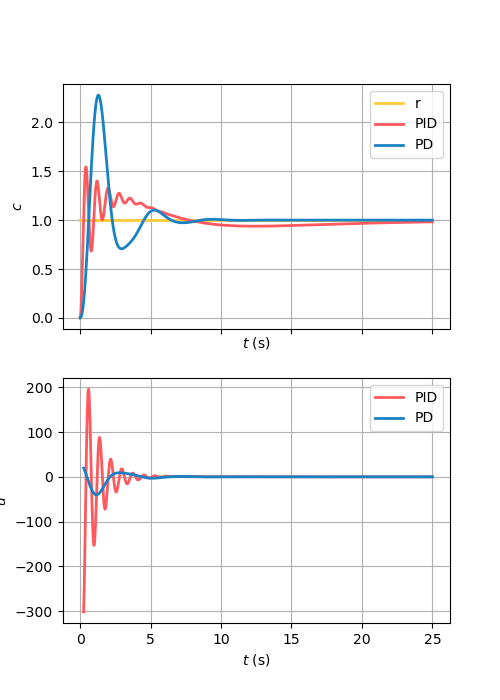

In [42]:
# simulação do sistema em MF
ts = np.linspace(0, 25, 1000)

# t, y_PI = ct.step_response(rc_tf_PI, ts)
# t, u_PI = ct.step_response(ru_tf_PI, ts)

t, y_PID = ct.step_response(rc_tf_PID, ts)
t, u_PID = ct.step_response(ru_tf_PID, ts)

t, y_PD = ct.step_response(rc_tf_PD, ts)
t, u_PD = ct.step_response(ru_tf_PD, ts)

fig, (state, control_input) = plt.subplots(
    2, 1, figsize=(5, 7), sharex=True)

state.plot(t, np.ones(len(t)), color=cp['yellow'], label='r', linewidth=2)
# state.plot(t, y_PI, color=cp['green'], label='PI', linewidth=2)
state.plot(t, y_PID, color=cp['red'], label='PID', linewidth=2)
state.plot(t, y_PD, color=cp['blue'], label='PD', linewidth=2)
state.set_ylabel(r'$c$')
state.set_xlabel(r'$t$ (s)')
state.legend()
state.grid()

# control_input.plot(t[10:], u_PI[10:], color=cp['green'], 
#                    label='PI', linewidth=2)
control_input.plot(t[10:], u_PID[10:], color=cp['red'],
                   label='PID', linewidth=2)
control_input.plot(t[10:], u_PD[10:], color=cp['blue'],
                   label='PD', linewidth=2)
control_input.set_ylabel(r'$u$')
control_input.set_xlabel(r'$t$ (s)')
control_input.legend()
control_input.grid()

#### 4.4. Resposta a rampa

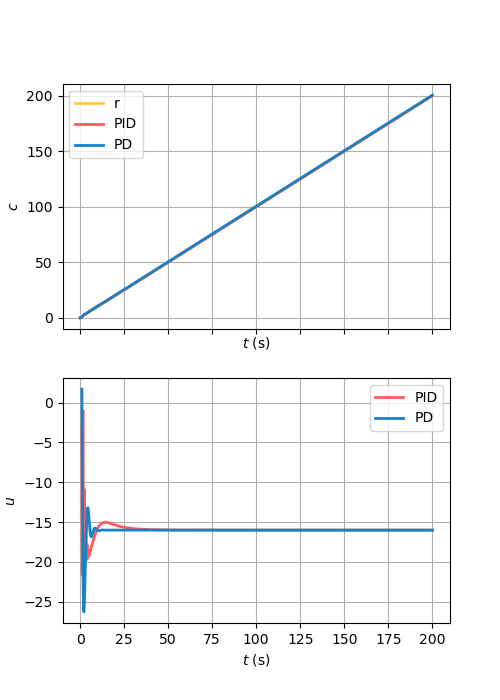

In [44]:
# simulação do sistema em MF
ts = np.linspace(0, 200, 2000)

# t, y_PI = ct.forced_response(rc_tf_PI, ts, U=ts)
# t, u_PI = ct.forced_response(ru_tf_PI, ts, U=ts)

t, y_PID = ct.forced_response(rc_tf_PID, ts, U=ts)
t, u_PID = ct.forced_response(ru_tf_PID, ts, U=ts)

t, y_PD = ct.forced_response(rc_tf_PD, ts, U=ts)
t, u_PD = ct.forced_response(ru_tf_PD, ts, U=ts)

fig, (state, control_input) = plt.subplots(
    2, 1, figsize=(5, 7), sharex=True)

state.plot(t, t, color=cp['yellow'], label='r', linewidth=2)
# state.plot(t, y_PI, color=cp['green'], label='PI', linewidth=2)
state.plot(t, y_PID, color=cp['red'], label='PID', linewidth=2)
state.plot(t, y_PD, color=cp['blue'], label='PD', linewidth=2)
state.set_ylabel(r'$c$')
state.set_xlabel(r'$t$ (s)')
state.legend()
state.grid()

# control_input.plot(t[10:], u_PI[10:], color=cp['green'],
#                    label='PI', linewidth=2)
control_input.plot(t[10:], u_PID[10:], color=cp['red'],
                   label='PID', linewidth=2)
control_input.plot(t[10:], u_PD[10:], color=cp['blue'],
                   label='PD', linewidth=2)
control_input.set_ylabel(r'$u$')
control_input.set_xlabel(r'$t$ (s)')
control_input.legend()
control_input.grid()